In [ ]:
from model import Model, Layer
from model import train_model
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
# training set for the PDE
xmin = -1.0
xmax = 1.0
ymin = -1.0
ymax = 1.0
pde_point_count = 8000

# generate random points in (-1, 1) x (-1, 1)
x = xmin + (xmax - xmin) * np.random.rand(pde_point_count, 1)
y = ymin + (ymax - ymin) * np.random.rand(pde_point_count, 1)

xy_train = tf.Variable(np.hstack((x, y)), dtype='float32')
train_min = np.hstack((xmin, ymin))
train_max = np.hstack((xmax, ymax))

# training set for the BC
bc_point_count_each = 100

# top and bottom boundary
b_x = xmin + (xmax - xmin) * np.random.rand(bc_point_count_each, 1)
b_x_ymin = tf.Variable(np.hstack((b_x, ymin * np.ones_like(b_x))), dtype='float32')
b_x_ymax = tf.Variable(np.hstack((b_x, ymax * np.ones_like(b_x))), dtype='float32')


# left and right boundary
b_y = ymin + (ymax - ymin) * np.random.rand(bc_point_count_each, 1)
b_xmin_y = tf.Variable(np.hstack((xmin * np.ones_like(b_y), b_y)), dtype='float32')
b_xmax_y = tf.Variable(np.hstack((xmax * np.ones_like(b_y), b_y)), dtype='float32')

In [ ]:
# DNN model
model = Model([
    Layer(input_dim=2, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=1, activation=None),
], train_min, train_max)

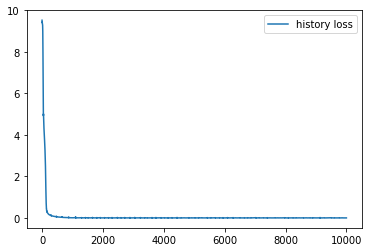

Final loss score: 7.00329546816647e-05


In [4]:
epochs = 10000
history_loss = train_model(model, xy_train, b_x_ymin, b_x_ymax, b_xmin_y, b_xmax_y, w1=0.1, w2=1, epochs=epochs, learning_rate=0.0008)

# plot for the loss score in the training loop
plt.plot(np.array(range(epochs)) + 1, history_loss, label='history loss')
plt.legend()
plt.show()
plt.close()

print(f'Final loss score: {history_loss[-1]}')

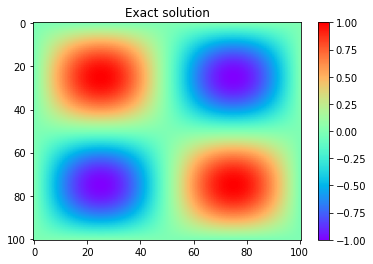

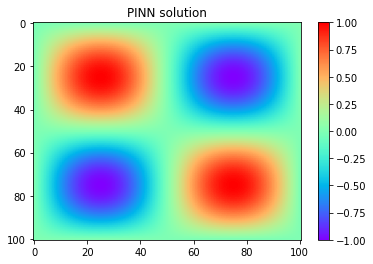

In [6]:
# exact solution
def exact_solution(x, y, xmin, xmax, ymin, ymax):
    return np.sin(2 * np.pi * x / (xmax - xmin)) * np.sin(2 * np.pi * y / (ymax - ymin))

# generate test set
x_test = np.linspace(xmin, xmax, 101).reshape((-1, 1))
y_test = np.linspace(ymin, ymax, 101).reshape((-1, 1))
x_t, y_t = np.meshgrid(x_test, y_test)
x_t = np.reshape(x_t, (-1, 1))
y_t = np.reshape(y_t, (-1, 1))

# plot exact solution
u_e = exact_solution(x_t, y_t, xmin, xmax, ymin, ymax)
u_e = np.reshape(u_e, (y_test.shape[0], x_test.shape[0]))
u_e = np.transpose(u_e)

plt.imshow(u_e, cmap='rainbow', aspect='auto')
plt.colorbar()
plt.title('Exact solution')
plt.savefig('./output/u_exact.png')
plt.show()
plt.close()

# plot prediction
test_set = tf.Variable(np.hstack((x_t, y_t)), dtype='float32')
u_pred = model(test_set)
u_pred = np.reshape(u_pred, (y_test.shape[0], x_test.shape[0]))
u_pred = np.transpose(u_pred)
plt.imshow(u_pred, cmap='rainbow', aspect='auto')
plt.colorbar()
plt.title('PINN solution')
plt.savefig('./output/u_pred.png')
plt.show()
plt.close()

# save test data and plot
np.savetxt('./output/u_pred.txt', u_pred, fmt='%e')
np.savetxt('./output/u_exact.txt', u_e, fmt='%e')